In [91]:
from __future__ import print_function
import argparse
import os
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable
from functions import *
from model import *

In [92]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='mnist', help='cifar10 | imagenet | mnist')
parser.add_argument('--dataroot', default='./datasets/', help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=32, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=256, help='size of the latent z vector')
parser.add_argument('--niterC', type=int, default=20, help='number of epochs to train the classifier')
parser.add_argument('--nf', type=int, default=64, help='filters factor')
parser.add_argument('--drop', type=float, default=0.0, help='probably of drop out')
parser.add_argument('--lrC', type=float, default=0.2, help='learning rate of the classifier, default=0.0002')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--outf', default='output', help='folder to output images and model checkpoints')
parser.add_argument('--num_classes', type=int, default=10, help='Number of classes for AC-GAN')
parser.add_argument('--gpu_id', type=str, default='0', help='The ID of the specified GPU')

opt, unknown = parser.parse_known_args()
print(opt)

Namespace(dataset='mnist', dataroot='./datasets/', workers=2, batchSize=64, imageSize=32, nz=256, niterC=20, nf=64, drop=0.0, lrC=0.2, ngpu=1, outf='output', num_classes=10, gpu_id='0')


In [93]:
# specify the gpu id if using only 1 gpu
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_id

dir_files = './results/'+opt.dataset+'/'+opt.outf
dir_checkpoint = './checkpoints/'+opt.dataset+'/'+opt.outf
try:
    os.makedirs(dir_files)
except OSError:
    pass
try:
    os.makedirs(dir_checkpoint)
except OSError:
    pass
    

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if opt.dataset == 'cifar10':
    n_train = 50000
    n_test = 10000
elif opt.dataset == 'svhn':
    n_train = 73257
    n_test = 26032
elif opt.dataset == 'mnist':
    n_train = 50000
    n_test = 10000
elif opt.dataset == 'fashion':
    n_train = 50000
    n_test = 10000


In [94]:
# get train dataset
dataset, unorm, img_channels = get_dataset(dataset_name=opt.dataset, dataroot=opt.dataroot, imageSize=opt.imageSize, is_train=True, drop_rate=0.0)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=n_train, shuffle=True, num_workers=int(opt.workers), drop_last=True)

# get test dataset
test_dataset, unorm, img_channels = get_dataset(dataset_name=opt.dataset, dataroot=opt.dataroot, imageSize=opt.imageSize, is_train=False, drop_rate=0.0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=n_test, shuffle=False, num_workers=int(opt.workers), drop_last=True)

In [95]:
# some hyper parameters
ngpu = int(opt.ngpu)
nz = int(opt.nz)
num_classes = int(opt.num_classes)
batch_size = opt.batchSize

# initiate networks
netG = Generator(ngpu, latent_dim=nz, ngf=opt.nf, img_channels=img_channels)
netG.apply(initialize_weights)
netD = Discriminator(ngpu, latent_dim=nz, ndf=opt.nf, img_channels=img_channels)
netD.apply(initialize_weights)
# send to GPU
netD.to(device)
netG.to(device)

Generator(
  (tconv1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

In [96]:
if os.path.exists(dir_checkpoint+'/trained.pth'):
    # Load data from last checkpoint
    print('Loading pre-trained model...')
    checkpoint = torch.load(dir_checkpoint+'/trained.pth', map_location='cpu')
    netG.load_state_dict(checkpoint['generator'])
    netD.load_state_dict(checkpoint['discriminator'])
    d_losses = checkpoint.get('d_losses', [float('inf')])
    g_losses = checkpoint.get('g_losses', [float('inf')])
    r_losses = checkpoint.get('r_losses', [float('inf')])
    print('Use loaded model...')
else:
    print('No pre-trained model detected, use randomly initialized network...')

Loading pre-trained model...
Use loaded model...


In [97]:
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

if os.path.exists(dir_files+'/accuracies.pth'):
    # Load data from last checkpoint
    print('Loading accuracies...')
    checkpoint = torch.load(dir_files+'/accuracies.pth', map_location='cpu')
    train_accuracies = checkpoint.get('train_accuracies', [float('inf')])
    test_accuracies = checkpoint.get('test_accuracies', [float('inf')])
    train_losses = checkpoint.get('train_losses', [float('inf')])
    test_losses = checkpoint.get('test_losses', [float('inf')])
else:
    print('No accuracies found...')

No accuracies found...


In [98]:
# project all train images on latent space
print("Storing training representations ...")
image, label = next(iter(train_dataloader))
image, label = image.to(device), label.to(device)
netD.eval()
with torch.no_grad():
    latent_output, _ = netD(image)
    train_features = latent_output.cpu()
    train_labels = label.cpu().long()

Storing training representations ...


In [99]:
# project all test images on latent space
print("Storing validation representations ...")
image, label = next(iter(test_dataloader))
image, label = image.to(device), label.to(device)
netD.eval()
with torch.no_grad():
    latent_output, _ = netD(image)
    test_features = latent_output.cpu()
    test_labels = label.cpu().long()

Storing validation representations ...


In [100]:
# create new datasets of latent vectors
linear_train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
linear_test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
# create new dataloaders of latent vectors
linear_train_loader = torch.utils.data.DataLoader(linear_train_dataset, batch_size=batch_size, shuffle=True, num_workers=opt.workers, drop_last=True)
linear_test_loader = torch.utils.data.DataLoader(linear_test_dataset, batch_size=batch_size, shuffle=False, num_workers=opt.workers, drop_last=True)


In [101]:
# nb of epochs to train linear classifier
n_epochs_c = opt.niterC
# loss function for linear classifier
class_criterion = nn.CrossEntropyLoss()

In [102]:
# # initialize linear classifier
# classifier = OutputClassifier(nz, num_classes=num_classes)
# classifier.to(device)
# optimizerC = optim.SGD(classifier.parameters(), lr=opt.lrC)

# for epoch in range(n_epochs_c):

#     store_train_acc = []
#     store_test_acc = []
#     store_train_loss = []
#     store_test_loss = []

#     print("training on train set...")

#     for feature, label in linear_train_loader:
#         feature, label = feature.to(device), label.to(device)
#         classifier.train()
#         optimizerC.zero_grad()
#         class_output = classifier(feature)
#         # compute classif error
#         class_err = class_criterion(class_output, label)
#         # update classifier with backprop
#         class_err.backward()
#         optimizerC.step()
#         # store train metrics
#         train_acc = compute_acc(class_output, label)
#         store_train_acc.append(train_acc)
#         store_train_loss.append(class_err.item())


#     print("testing on test set...")
#     # compute test accuracy
#     for feature, label in linear_test_loader:
#         feature, label = feature.to(device), label.to(device)
#         classifier.eval()
#         class_output = classifier(feature)
#         class_err = class_criterion(class_output, label)
#         # store test metrics
#         test_acc = compute_acc(class_output, label)
#         store_test_acc.append(test_acc)
#         store_test_loss.append(class_err.item())

#     print('[%d/%d]  train_loss: %.4f  test_loss: %.4f  train_acc: %.4f  test_acc: %.4f'
#               % (epoch, n_epochs_c, np.mean(store_train_loss), np.mean(store_test_loss), np.mean(store_train_acc), np.mean(store_test_acc)))



# torch.save({
#     'classifier': classifier.state_dict(),
# }, dir_checkpoint + '/trained_classifier.pth')
# print(f'Classifier successfully saved.')


# # train average metrics
# train_accuracies.append(np.mean(store_train_acc))
# train_losses.append(np.mean(store_train_loss))
# # test average metrics
# test_accuracies.append(np.mean(store_test_acc))
# test_losses.append(np.mean(store_test_loss))

# # do checkpointing
# torch.save({
#     'train_accuracies': train_accuracies,
#     'test_accuracies': test_accuracies,
#     'train_losses': train_losses,
#     'test_losses': test_losses,
# }, dir_files+'/accuracies.pth')
# print(f'Accuracies successfully saved.')


# # Plot losse and accuracies during training
# e = np.arange(0, len(train_accuracies))
# fig = plt.figure(figsize=(10, 5))
# ax1 = fig.add_subplot(121)
# ax1.plot(e, train_losses, label='train loss')
# ax1.plot(e, test_losses, label='test loss')
# ax1.set_xlabel('epochs')
# ax1.set_ylabel('loss')
# ax1.set_title('losses with uns. training')
# ax1.legend()

# ax2 = fig.add_subplot(122)
# ax2.plot(e, train_accuracies, label='train acc')
# ax2.plot(e, test_accuracies, label='test acc')
# ax2.set_ylim(0, 100)
# ax2.set_xlabel('epochs')
# ax2.set_ylabel('accuracy (%)')
# ax2.set_title('accuracy with uns. training')
# ax2.legend()

# fig.savefig(dir_files + '/linear_classif.pdf')






training on train set...
testing on test set...
[0/20]  train_loss: 0.1793  test_loss: 0.1199  train_acc: 94.6243  test_acc: 96.4343
training on train set...
testing on test set...
[1/20]  train_loss: 0.1235  test_loss: 0.1044  train_acc: 96.2248  test_acc: 96.6647
training on train set...
testing on test set...
[2/20]  train_loss: 0.1116  test_loss: 0.0968  train_acc: 96.5089  test_acc: 96.9752
training on train set...
testing on test set...
[3/20]  train_loss: 0.1043  test_loss: 0.0944  train_acc: 96.7910  test_acc: 97.0353
training on train set...
testing on test set...
[4/20]  train_loss: 0.0996  test_loss: 0.0905  train_acc: 96.9050  test_acc: 97.3357
training on train set...
testing on test set...
[5/20]  train_loss: 0.0955  test_loss: 0.0849  train_acc: 97.0190  test_acc: 97.4058
training on train set...
testing on test set...
[6/20]  train_loss: 0.0930  test_loss: 0.0851  train_acc: 97.0831  test_acc: 97.3858
training on train set...
testing on test set...
[7/20]  train_loss: 0

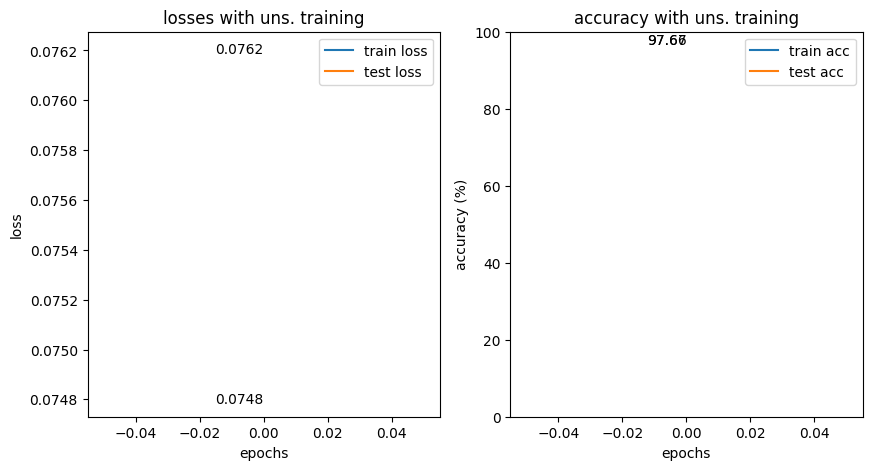

In [103]:
# # initialize linear classifier
# classifier = OutputClassifier(nz, num_classes=num_classes)
# classifier.to(device)
# optimizerC = optim.SGD(classifier.parameters(), lr=opt.lrC)

# for epoch in range(n_epochs_c):

#     store_train_acc = []
#     store_test_acc = []
#     store_train_loss = []
#     store_test_loss = []

#     print("training on train set...")

#     for feature, label in linear_train_loader:
#         feature, label = feature.to(device), label.to(device)
#         classifier.train()
#         optimizerC.zero_grad()
#         class_output = classifier(feature)
#         # compute classif error
#         class_err = class_criterion(class_output, label)
#         # update classifier with backprop
#         class_err.backward()
#         optimizerC.step()
#         # store train metrics
#         train_acc = compute_acc(class_output, label)
#         store_train_acc.append(train_acc)
#         store_train_loss.append(class_err.item())


#     print("testing on test set...")
#     # compute test accuracy
#     for feature, label in linear_test_loader:
#         feature, label = feature.to(device), label.to(device)
#         classifier.eval()
#         class_output = classifier(feature)
#         class_err = class_criterion(class_output, label)
#         # store test metrics
#         test_acc = compute_acc(class_output, label)
#         store_test_acc.append(test_acc)
#         store_test_loss.append(class_err.item())

#     print('[%d/%d]  train_loss: %.4f  test_loss: %.4f  train_acc: %.4f  test_acc: %.4f'
#               % (epoch, n_epochs_c, np.mean(store_train_loss), np.mean(store_test_loss), np.mean(store_train_acc), np.mean(store_test_acc)))



# torch.save({
#     'classifier': classifier.state_dict(),
# }, dir_checkpoint + '/trained_classifier.pth')
# print(f'Classifier successfully saved.')


# # train average metrics
# train_accuracies.append(np.mean(store_train_acc))
# train_losses.append(np.mean(store_train_loss))
# # test average metrics
# test_accuracies.append(np.mean(store_test_acc))
# test_losses.append(np.mean(store_test_loss))

# # do checkpointing
# torch.save({
#     'train_accuracies': train_accuracies,
#     'test_accuracies': test_accuracies,
#     'train_losses': train_losses,
#     'test_losses': test_losses,
# }, dir_files+'/accuracies.pth')
# print(f'Accuracies successfully saved.')


# # Plot losses and accuracies during training
# e = np.arange(0, len(train_losses))
# fig = plt.figure(figsize=(10, 5))
# ax1 = fig.add_subplot(121)
# ax1.plot(e, train_losses, label='train loss')
# ax1.plot(e, test_losses, label='test loss')
# ax1.set_xlabel('epochs')
# ax1.set_ylabel('loss')
# ax1.set_title('losses with uns. training')
# ax1.legend()

# # Display current values on the plot
# ax1.text(e[-1], train_losses[-1], f'{train_losses[-1]:.4f}', ha='right', va='center')
# ax1.text(e[-1], test_losses[-1], f'{test_losses[-1]:.4f}', ha='right', va='center')

# ax2 = fig.add_subplot(122)
# ax2.plot(e, train_accuracies, label='train acc')
# ax2.plot(e, test_accuracies, label='test acc')
# ax2.set_ylim(0, 100)
# ax2.set_xlabel('epochs')
# ax2.set_ylabel('accuracy (%)')
# ax2.set_title('accuracy with uns. training')
# ax2.legend()
# # Display current values on the plot
# ax2.text(e[-1], train_accuracies[-1], f'{train_accuracies[-1]:.2f}', ha='right', va='center')
# ax2.text(e[-1], test_accuracies[-1], f'{test_accuracies[-1]:.2f}', ha='right', va='center')

# plt.show()

# fig.savefig(dir_files + '/linear_classif.pdf')






training on train set...
testing on test set...
[0/20]  train_loss: 0.1792  test_loss: 0.1186  train_acc: 94.6803  test_acc: 96.4143
training on train set...
testing on test set...
[1/20]  train_loss: 0.1239  test_loss: 0.1065  train_acc: 96.2208  test_acc: 96.6446
training on train set...
testing on test set...
[2/20]  train_loss: 0.1114  test_loss: 0.0982  train_acc: 96.6289  test_acc: 96.9351
training on train set...
testing on test set...
[3/20]  train_loss: 0.1049  test_loss: 0.0898  train_acc: 96.7570  test_acc: 97.2556
training on train set...
testing on test set...
[4/20]  train_loss: 0.0996  test_loss: 0.0878  train_acc: 96.9510  test_acc: 97.2857
training on train set...
testing on test set...
[5/20]  train_loss: 0.0960  test_loss: 0.0848  train_acc: 97.0290  test_acc: 97.3057
training on train set...
testing on test set...
[6/20]  train_loss: 0.0931  test_loss: 0.0853  train_acc: 97.1191  test_acc: 97.3357
training on train set...
testing on test set...
[7/20]  train_loss: 0

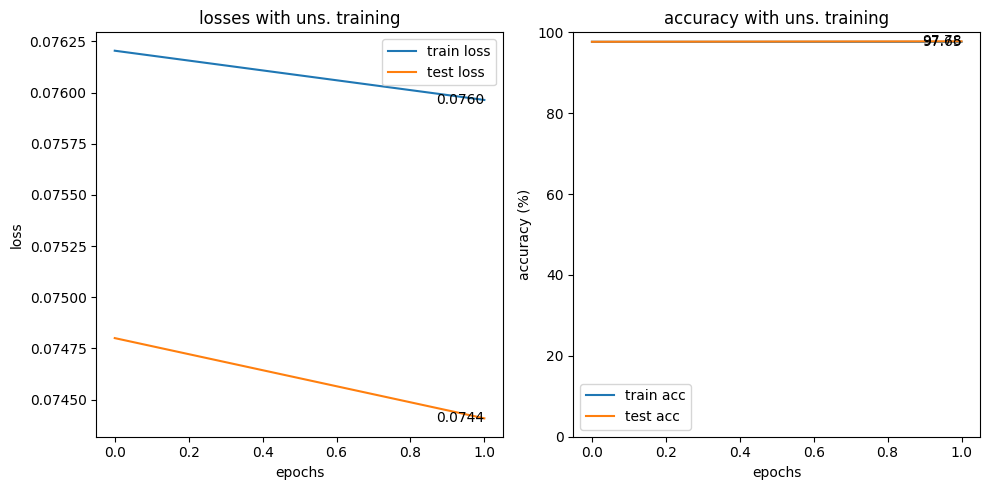

In [108]:
# initialize linear classifier
classifier = OutputClassifier(nz, num_classes=num_classes)
classifier.to(device)
optimizerC = optim.SGD(classifier.parameters(), lr=opt.lrC)

for epoch in range(n_epochs_c):

    store_train_acc = []
    store_test_acc = []
    store_train_loss = []
    store_test_loss = []

    print("training on train set...")

    for feature, label in linear_train_loader:
        feature, label = feature.to(device), label.to(device)
        classifier.train()
        optimizerC.zero_grad()
        class_output = classifier(feature)
        # compute classif error
        class_err = class_criterion(class_output, label)
        # update classifier with backprop
        class_err.backward()
        optimizerC.step()
        # store train metrics
        train_acc = compute_acc(class_output, label)
        store_train_acc.append(train_acc)
        store_train_loss.append(class_err.item())


    print("testing on test set...")
    # compute test accuracy
    for feature, label in linear_test_loader:
        feature, label = feature.to(device), label.to(device)
        classifier.eval()
        class_output = classifier(feature)
        class_err = class_criterion(class_output, label)
        # store test metrics
        test_acc = compute_acc(class_output, label)
        store_test_acc.append(test_acc)
        store_test_loss.append(class_err.item())

    print('[%d/%d]  train_loss: %.4f  test_loss: %.4f  train_acc: %.4f  test_acc: %.4f'
              % (epoch, n_epochs_c, np.mean(store_train_loss), np.mean(store_test_loss), np.mean(store_train_acc), np.mean(store_test_acc)))



torch.save({
    'classifier': classifier.state_dict(),
}, dir_checkpoint + '/trained_classifier.pth')
print(f'Classifier successfully saved.')


# train average metrics
train_accuracies.append(np.mean(store_train_acc))
train_losses.append(np.mean(store_train_loss))
# test average metrics
test_accuracies.append(np.mean(store_test_acc))
test_losses.append(np.mean(store_test_loss))

# do checkpointing
torch.save({
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
    'train_losses': train_losses,
    'test_losses': test_losses,
}, dir_files+'/accuracies.pth')
print(f'Accuracies successfully saved.')

# Plot losses and accuracies during training
e = np.arange(0, len(train_losses))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(e, train_losses, label='train loss')
ax1.plot(e, test_losses, label='test loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('losses with uns. training')
ax1.legend()

# Display current values on the plot
ax1.text(e[-1], train_losses[-1], f'{train_losses[-1]:.4f}', ha='right', va='center')
ax1.text(e[-1], test_losses[-1], f'{test_losses[-1]:.4f}', ha='right', va='center')

ax2.plot(e, train_accuracies, label='train acc')
ax2.plot(e, test_accuracies, label='test acc')
ax2.set_ylim(0, 100)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy (%)')
ax2.set_title('accuracy with uns. training')
ax2.legend()

# Display current values on the plot
ax2.text(e[-1], train_accuracies[-1], f'{train_accuracies[-1]:.2f}', ha='right', va='center')
ax2.text(e[-1], test_accuracies[-1], f'{test_accuracies[-1]:.2f}', ha='right', va='center')

fig.savefig(dir_files + '/linear_classif.pdf')


plt.tight_layout()
plt.show()



In [104]:
# Evaluate linear classifier on test set
predictions = []
true_labels = []
for feature, label in linear_test_loader:
    feature = feature.to(device)
    classifier.eval()
    class_output = classifier(feature)
    _, predicted_labels = torch.max(class_output, 1)
    predictions.extend(predicted_labels.cpu().numpy())
    true_labels.extend(label.cpu().numpy())

In [105]:
 cm = confusion_matrix(true_labels, predictions)

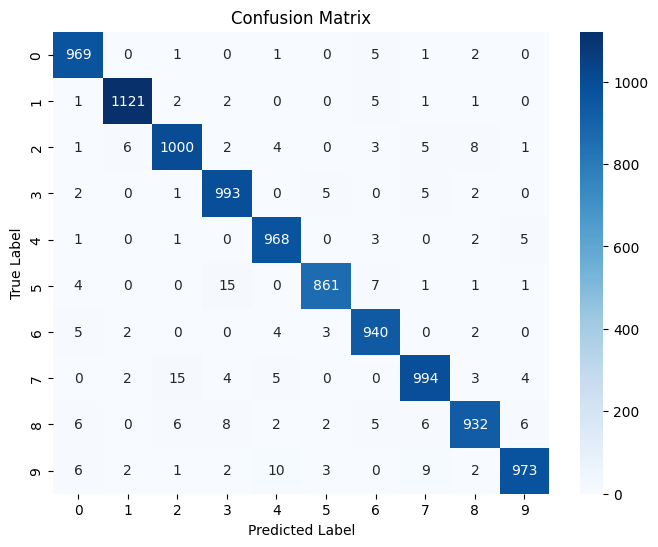

In [106]:
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()